In [1]:
from __future__ import absolute_import, division, print_function
import numpy as np
import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output, Image, display, HTML
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics as sk_metrics
import time
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers, layers, models
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from tensorflow.keras import backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from sklearn.metrics import confusion_matrix, classification_report
# import warnings
# warnings.filterwarnings('ignore')

In [2]:
## set train, validation, and test paths
train_path = '../input/dataset2/dataset70-10-20/train/Vegetables'
validation_path = '../input/dataset2/dataset70-10-20/val/Vegetables'
test_path = '../input/dataset2/dataset70-10-20/test/Vegetables'

In [3]:
packages_classes=[]
for root, subdirectories, files in os.walk(train_path):
    for subdirectory in subdirectories:
        packages_classes.append(subdirectory)
print(len(packages_classes))

22


In [4]:
train_batches  = ImageDataGenerator().flow_from_directory(
    train_path, target_size=(224, 224), classes = packages_classes, batch_size = 50)

validation_batches  = ImageDataGenerator().flow_from_directory(
    validation_path, target_size=(224, 224), classes = packages_classes, batch_size = 10)

test_batches  = ImageDataGenerator().flow_from_directory(
    test_path, target_size=(224, 224), classes = packages_classes, batch_size = 10)

Found 903 images belonging to 22 classes.
Found 122 images belonging to 22 classes.
Found 281 images belonging to 22 classes.


In [5]:
#take a look at output of the generators
for data_batch, labels_batch in train_batches:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (50, 224, 224, 3)
labels batch shape: (50, 22)


## Data Augmentation

In [6]:
## Augmentation datagenerator
train_datagen_aug = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        fill_mode='nearest',
        rescale=1./255,
        #shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

## train generator
train_generator_aug = train_datagen_aug.flow_from_directory(
        train_path,
        target_size=(224, 224),
        batch_size=25,
        class_mode='categorical')

## test generator, required for prediction
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(224, 224),
        batch_size=1,
        shuffle = False,
        class_mode='categorical')

## validation generator
val_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=(224, 224),
        batch_size=10,
        class_mode='categorical')

Found 903 images belonging to 22 classes.
Found 281 images belonging to 22 classes.
Found 122 images belonging to 22 classes.


In [7]:
## set steps per epoch for train
train_filenames = train_generator_aug.filenames
steps_train = len(train_filenames)/train_generator_aug.batch_size

## set steps per epoch for validation
val_filenames = val_generator.filenames
steps_val = len(val_filenames)/val_generator.batch_size

## test
filenames_test = test_generator.filenames
nb_samples_test= len(filenames_test)
true_classes = test_generator.classes
target_names = packages_classes

## Mobilenet with Augmentation and DropOut

In [8]:
base_model_mobilenet = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',include_top=False, input_shape=(224, 224, 3)) 

base_model_mobilenet.summary()

base_model_mobilenet.trainable = False

# for layer in base_model_mobilenet.layers[-10:]:
#     layer.trainable=True



User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
________________

In [9]:
translearn2_mobilenet = Sequential()
translearn2_mobilenet.add(base_model_mobilenet)
#translearn2_vgg16.add(Dense(256, activation = 'relu'))
translearn2_mobilenet.add(GlobalAveragePooling2D())
translearn2_mobilenet.add(Dropout(0.4))
translearn2_mobilenet.add(Dense(22, activation='softmax'))
translearn2_mobilenet.summary()

## compile model
translearn2_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=0.01),
              metrics=['acc'])

# Callbacks
# es = EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 6, verbose=1)
# mc = ModelCheckpoint("./vgg19_best2.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
# cb=[es, mc]

## fit model
model2_mobilenet = translearn2_mobilenet.fit(
        train_generator_aug,
        steps_per_epoch=steps_train,
        epochs=50,
        validation_data=val_generator,
        validation_steps=steps_val,
        verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 22)                28182     
Total params: 2,286,166
Trainable params: 28,182
Non-trainable params: 2,257,984
_________________________________________________________________


2021-12-22 13:30:38.498196: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
36/36 [==============================] - 28s 683ms/step - loss: 1.7193 - acc: 0.6113 - val_loss: 0.5211 - val_acc: 0.8689
Epoch 2/50
36/36 [==============================] - 22s 600ms/step - loss: 0.6478 - acc: 0.8228 - val_loss: 0.3657 - val_acc: 0.8934
Epoch 3/50
36/36 [==============================] - 21s 579ms/step - loss: 0.5597 - acc: 0.8594 - val_loss: 0.5972 - val_acc: 0.8361
Epoch 4/50
36/36 [==============================] - 21s 587ms/step - loss: 0.4776 - acc: 0.8893 - val_loss: 0.4339 - val_acc: 0.9016
Epoch 5/50
36/36 [==============================] - 22s 592ms/step - loss: 0.4825 - acc: 0.8771 - val_loss: 0.4421 - val_acc: 0.9426
Epoch 6/50
36/36 [==============================] - 21s 584ms/step - loss: 0.4505 - acc: 0.8970 - val_loss: 0.3935 - val_acc: 0.9262
Epoch 7/50
36/36 [==============================] - 21s 576ms/step - loss: 0.5557 - acc: 0.8893 - val_loss: 0.4055 - val_acc: 0.9016
Epoch 8/50
36/36 [==============================] - 21s 586ms/step - 

In [12]:
translearn2_mobilenet.save('veg_mobilenet.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


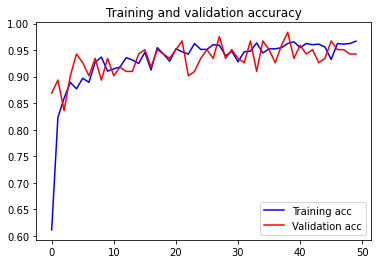

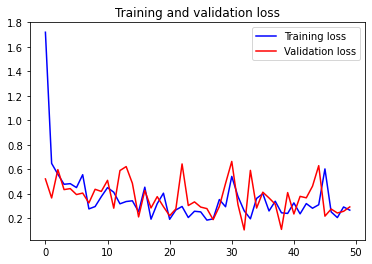

In [13]:
acc = model2_mobilenet.history['acc']
val_acc = model2_mobilenet.history['val_acc']
loss = model2_mobilenet.history['loss']
val_loss = model2_mobilenet.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
translearn3_mobilenet = Sequential()
translearn3_mobilenet.add(base_model_mobilenet)
#translearn3_vgg16.add(Dense(512, activation = 'relu'))
translearn3_mobilenet.add(GlobalAveragePooling2D())
translearn3_mobilenet.add(Dropout(0.4))
translearn3_mobilenet.add(Dense(22, activation='softmax'))
translearn3_mobilenet.summary()

## compile model
translearn3_mobilenet.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

# Callbacks
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01,patience= 2, verbose=1)
mc = ModelCheckpoint("mobilenet_best3.h5", monitor='val_accuracy', verbose=1, save_best_only=True)
cb=[es, mc]

## fit model
model3_mobilenet = translearn3_mobilenet.fit(
        train_generator_aug,
        steps_per_epoch=steps_train,
        epochs=200,
        validation_data=val_generator,
        validation_steps=steps_val,
        verbose=1,
        callbacks=[cb])

## Predict

In [15]:
mobilenet_pred= translearn2_mobilenet.predict(test_generator, steps = nb_samples_test, verbose=2)
mobilenet_y_pred1 = mobilenet_pred.argmax(axis=1)

281/281 - 9s


### Confusion Matrix

Text(0.5, 1.0, 'Confusion Matrix')

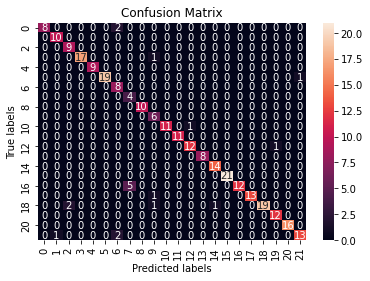

In [16]:
mobilenet_CM1 = confusion_matrix(mobilenet_y_pred1, true_classes)
ax= plt.subplot()
sns.heatmap(mobilenet_CM1, annot=True, fmt='g', ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix')
# ax.xaxis.set_ticklabels(['Fruit', 'Packages', 'Vegetables']) 
# ax.yaxis.set_ticklabels(['Fruit', 'Packages', 'Vegetables'])

### Classification Report

In [17]:
print(classification_report(true_classes, mobilenet_y_pred1, target_names=target_names))

                    precision    recall  f1-score   support

              Leek       0.80      1.00      0.89         8
      Solid-Potato       1.00      0.91      0.95        11
            Ginger       1.00      0.82      0.90        11
          Zucchini       0.94      1.00      0.97        17
   Red-Bell-Pepper       1.00      1.00      1.00         9
      Sweet-Potato       0.95      1.00      0.97        19
       Beef-Tomato       1.00      0.67      0.80        12
     Floury-Potato       1.00      0.44      0.62         9
       Vine-Tomato       1.00      1.00      1.00        10
    Regular-Tomato       1.00      0.67      0.80         9
Yellow-Bell-Pepper       0.92      1.00      0.96        11
      Yellow-Onion       1.00      1.00      1.00        11
          Red-Beet       0.92      0.92      0.92        13
         Asparagus       1.00      1.00      1.00         8
         Aubergine       1.00      0.93      0.97        15
           Cabbage       1.00      1.00

In [18]:
translearn3_mobilenet.save('mobilenet_veges.h5')


NameError: name 'translearn3_mobilenet' is not defined